# Проект 

### План проекта 
[**Шаг 0. Импорт библиотек, методы**](#step_00)

[**Задача 1**](#task_01)

[**Шаг 1. Загрузка данных**](#step_01)

[**Шаг 2. Предобработка данных**](#step_02)

[**Шаг 3. Исследовательский анализ**](#step_03)

[**Шаг 4. Подготовка данных, обучение модели**](#step_04)

[**Задача 2**](#task_02)








# Методы 

<a id="step_00"></a>

In [1]:
#импорт нужных библиотек
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from scipy.stats import shapiro
import shap

from sklearn.compose import ColumnTransformer
from sklearn.impute import  SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import FunctionTransformer



def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


RANDOM_STATE = 42

/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def duplicates(columns, df):
    for column in columns:
        unique_values = df[column].unique()
        print(f'Уникальные значения в колонке {column}: {unique_values}')

In [3]:
def create_histogram(data, column):
    """
    Input:
    - data: Датафрейм, содержащий данные.
    - column: Наименование столбца, для которого нужно построить гистограмму.
    - title: Заголовок гистограммы.
    - bins: Количество бинов для гистограммы (по умолчанию 50)

    Output:
    - None

    Description:
    Функция создает гистограмму для указанного столбца в датафрейме при помощи библиотеки seaborn. 
    Результат выводится на экран.
    """
    plt.figure(figsize=(12, 6))
    sns.set()
    num_bins = int(np.ceil(np.sqrt(len(data[column]))))
    sns.histplot(data=data, x=column, kde=True, bins=num_bins)
    plt.title(f'{column} - Плотность распределения', fontsize=18)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.show()

In [4]:
def create_barplot(data, column, rotation=45):
    """
    Input:
    - data (DataFrame): Исходный DataFrame с данными.
    - column (str): Название колонки, для которой нужно построить диаграмму.
    - title (str): Заголовок для столбчатой диаграммы.
    
    Output:
    None

    Description:
    Функция создает столбчатую диаграмму на основе данных из указанной колонки.
    """
    plt.figure(figsize=(10, 6))
    plt.xticks(rotation=rotation)
    new_data = data[column].value_counts()
    df_new_data = new_data.reset_index()
    df_new_data.columns = [column, 'count']

    sns.barplot(x=column, y='count', data = df_new_data)
    plt.title(f'{column}.Плотность распределения')
    plt.xlabel(f'{column}')
    plt.ylabel(f'количество {column}')

In [5]:
def cat_num_col(df):
    """
    Input:
    - df(DataDrame): Исходный DataFrame с данными
    Output:
    - num_col_names(list) - список столбцов с количественными признаками
    - cat_col_names(list) - список столбцов с категориальными признаками

    Description:
    Функция возвращает списки с названиями столбцов категориальных и количественных признаков. id из списка удаляется

    """
    num_col_names = list(df.select_dtypes(include=['int64', 'float64']).columns)
    cat_col_names = list(df.select_dtypes(include=['object']).columns)
    num_col_names.remove('id')
    return num_col_names, cat_col_names

In [6]:
def shapiro_test(data, column):
    """
    Функция выполняет тест Шапиро-Уилка на нормальность данных в указанном столбце.

    Параметры:
        - data: pandas DataFrame, входные данные
        - column: str, название столбца, для которого выполняется тест

    Вывод:
        - печать результата теста Шапиро-Уилка, включая статистику теста и p-значение
        - вывод сообщения о том, является ли распределение данных нормальным
    """ 
    statistic, p_value = shapiro(data[column])

    # Печать результата теста
    alpha = 0.05  # Уровень значимости
    print(f'Результат теста Шапиро-Уилка для столбца {column}:')
    print(f'Статистика теста: {statistic}')
    print(f'p-значение: {p_value}')
    if p_value > alpha:
        print('Распределение данных является нормальным.')
    else:
        print('Распределение данных не является нормальным.')

In [7]:
def scatter_dataframe(df):
    num_cols = df.select_dtypes(exclude='object').columns.to_list()
    parameters = []
    for i in num_cols:
        for j in num_cols:
            if (i != j) and (i != 'id') and (j != 'id'):
                if ((i, j) not in parameters) and ((j, i) not in parameters):
                    df.plot(x=i, y=j, kind='scatter')
                    k = i, j
                    parameters.append(k)
    None

In [8]:
def create_boxplot(data, column):
    """
    Input:
    - data (DataFrame): Исходный DataFrame с данными.
    - column (str): Название колонки, которая будет отображена на оси x.
    
    Output:
    None
    
    Description:
    Функция создает график ящика с усами на основе указанных столбцов.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[column])
    plt.title(f'Ящик с усами для {column}')
    plt.xlabel(column)
    plt.show()

In [9]:
def compare_df(df1, df2, column):
    # Создание сабплотов
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Первый график - барплот количества сотрудников в каждом департаменте
    sns.countplot(x=column, data=df1, ax=ax[0], palette='Set1')
    ax[0].set_title('Сотрудики, которые не уволились')

    # Второй график - барплот количества уволившихся сотрудников в каждом департаменте
    sns.countplot(x=column, data=df2, ax=ax[1], palette='Set2')
    ax[1].set_title('Сотрудики, которые уволились')

    plt.show()

# Задача 1 

<a id="task_01"></a>

# Этап 1. Загрузка данных

<a id="step_01"></a>

In [10]:
try:
    df_train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
    df_test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    df_test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')
except FileNotFoundError:
    print('Упc, кажется такого файла нет')

In [11]:
df_train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [12]:
df_train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [13]:
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [14]:
df_test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [15]:
df_test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [16]:
df_test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


## Вывод 
В качестве данных у нас 3 датафрейма. Тренирочая выборка, признаки тестовой выборки и целевой признак тестовой выборки. Все типы данных соотвествуют тем, что были даны в описании к названиям колонок.  В датафреймах df_test_features и df_train_job_satisfaction_rate есть пропуски 

# Этап 2 Предобработка данных

<a id="step_02"></a>

Проверим наличие дубликатов и не явных дубликатов. При необходимостии удалим дубли 

In [17]:
data_frames = [df_test_target_job_satisfaction_rate, df_test_features, df_train_job_satisfaction_rate]

for data in data_frames:
    data_name = [key for key, value in locals().items() if value is data][0]
    print(f'Количество дубликатов в датафрейме {data_name}: {data.duplicated().sum()}')
    if data.duplicated().sum() > 0:
        data.drop_duplicates(inplace=True)
        print(f'Количество дубликатов в датафрейме {data_name}: {data.duplicated().sum()}')

Количество дубликатов в датафрейме df_test_target_job_satisfaction_rate: 0
Количество дубликатов в датафрейме df_test_features: 0
Количество дубликатов в датафрейме df_train_job_satisfaction_rate: 0


In [18]:
num_col_train_job, cat_col_train_job = cat_num_col(df_train_job_satisfaction_rate)
num_col_test_features, cat_col_test_features = cat_num_col(df_test_features)


In [19]:
print('df_train_job_satisfaction_rate')
for col_name in cat_col_train_job:
    print(f'Количество уникальны значений в столбце {col_name}: {df_train_job_satisfaction_rate[col_name].unique()}')
print()
print('df_test_features')
for col_name in cat_col_test_features:
    print(f'Количество уникальны значений в столбце {col_name}: {df_test_features[col_name].unique()}')
    



df_train_job_satisfaction_rate
Количество уникальны значений в столбце dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Количество уникальны значений в столбце level: ['junior' 'middle' 'sinior' nan]
Количество уникальны значений в столбце workload: ['medium' 'high' 'low']
Количество уникальны значений в столбце last_year_promo: ['no' 'yes']
Количество уникальны значений в столбце last_year_violations: ['no' 'yes']

df_test_features
Количество уникальны значений в столбце dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Количество уникальны значений в столбце level: ['junior' 'middle' 'sinior' nan]
Количество уникальны значений в столбце workload: ['medium' 'low' 'high' ' ']
Количество уникальны значений в столбце last_year_promo: ['no' 'yes']
Количество уникальны значений в столбце last_year_violations: ['no' 'yes']


В столбцах  workload и dept датафрейма df_test_features есть пустые строки. Их заменим на nan для последующей обработки 

In [20]:
df_test_features['dept'].replace(' ', np.nan, inplace=True)
df_test_features['workload'].replace(' ', np.nan, inplace=True)

Проверим наличие пропусков. Удалять или как-то обрабатывать пропуски будем в следующем этапе. 

## Вывод 
В датафремах нет дубликатов. Пустые строки заменили на nan, пропуски обработаем в пайплайне. 

# Этап 3 Исследовательский анализ данных

<a id="step_03"></a>

Выведем графики для всех признаков

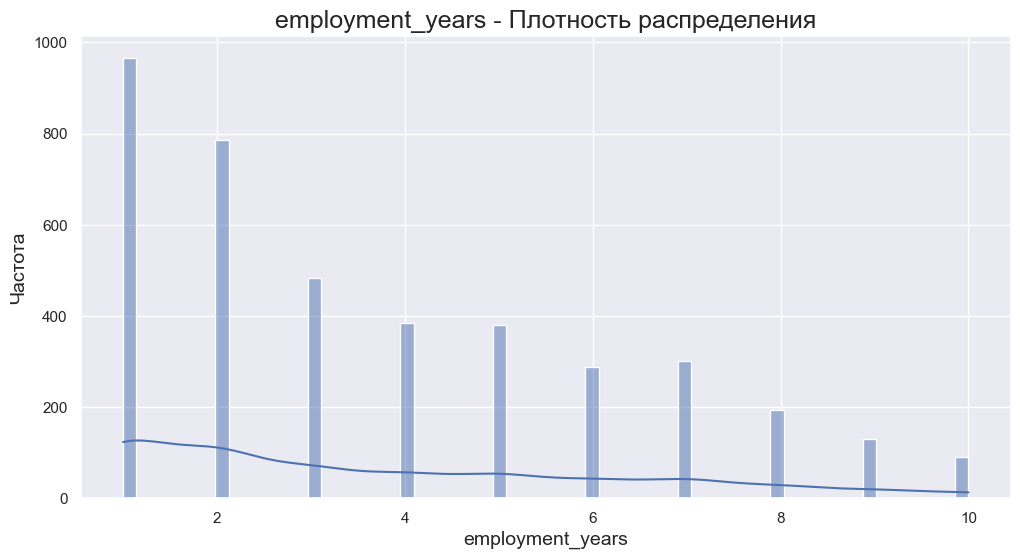

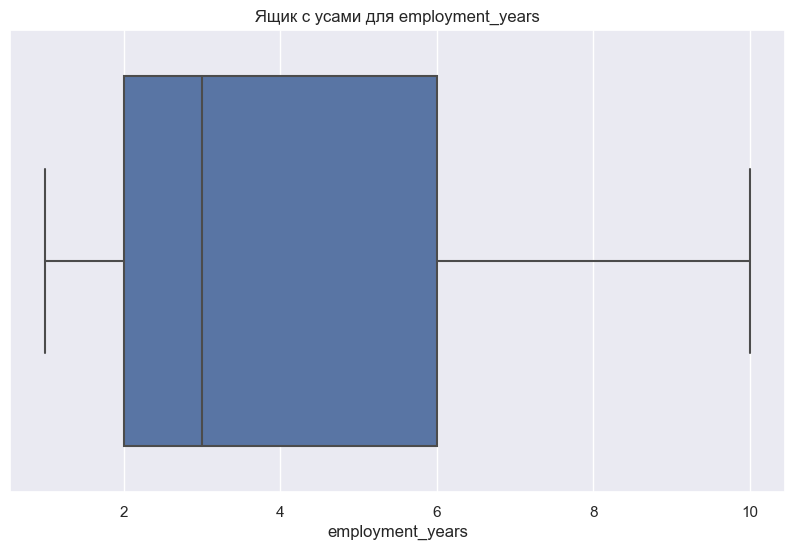

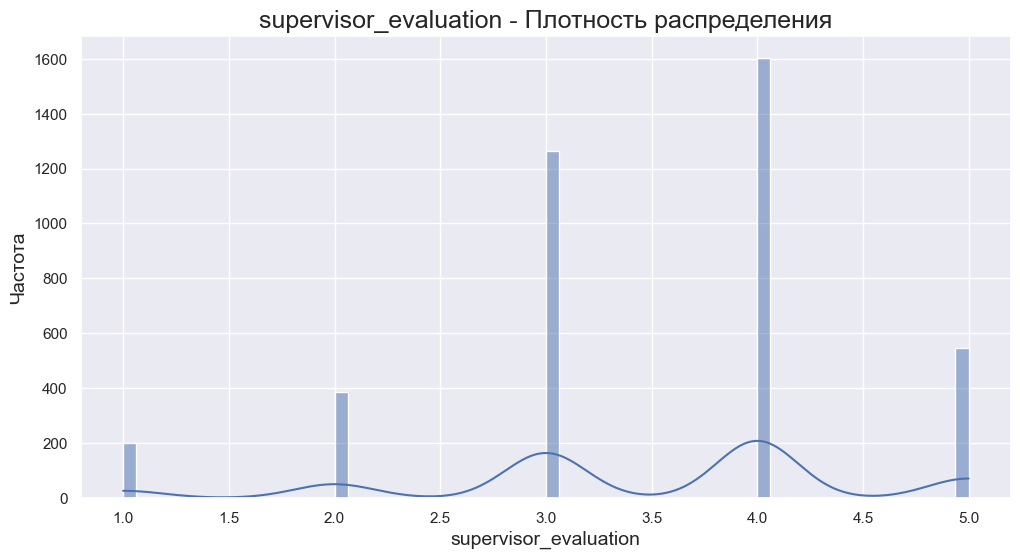

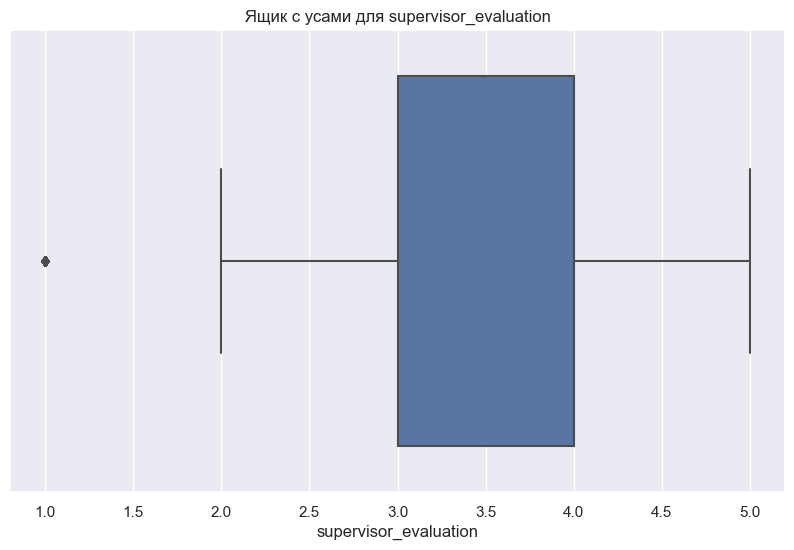

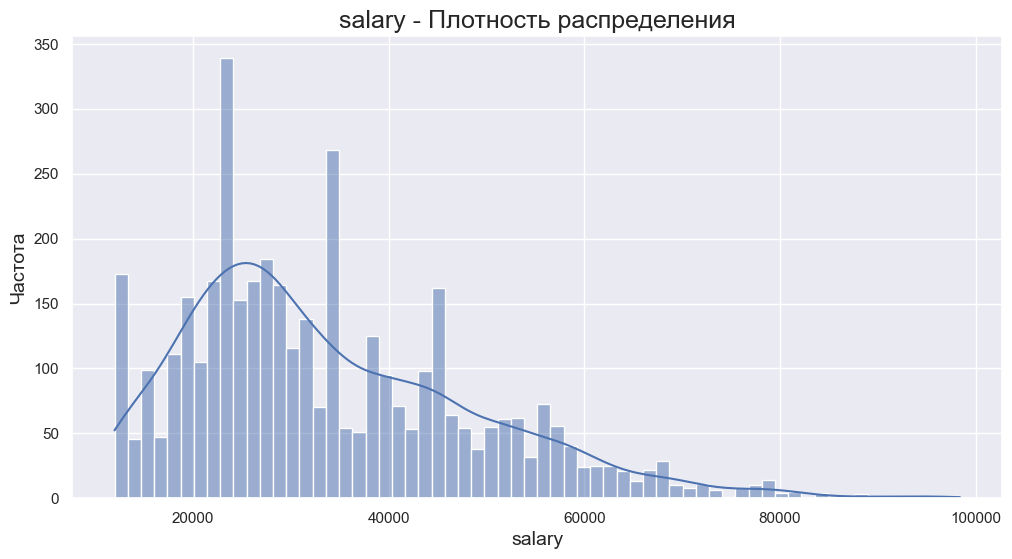

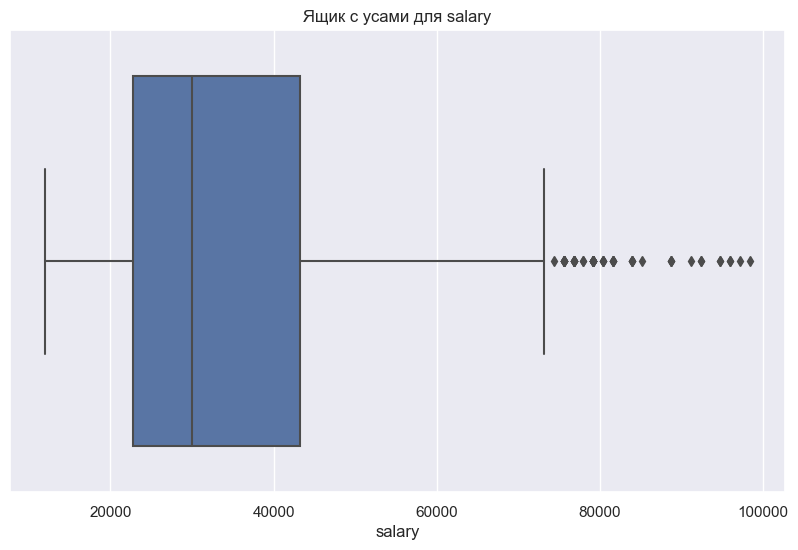

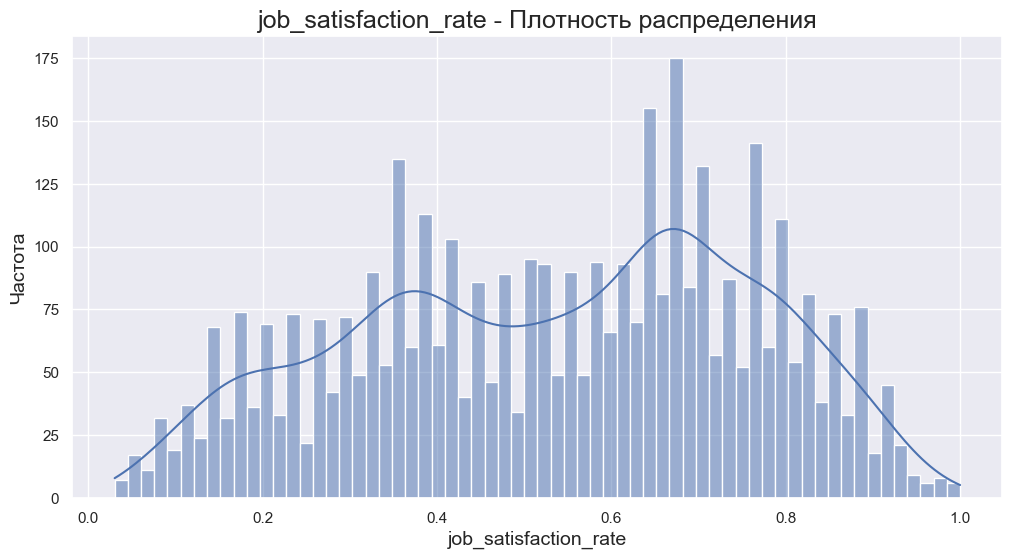

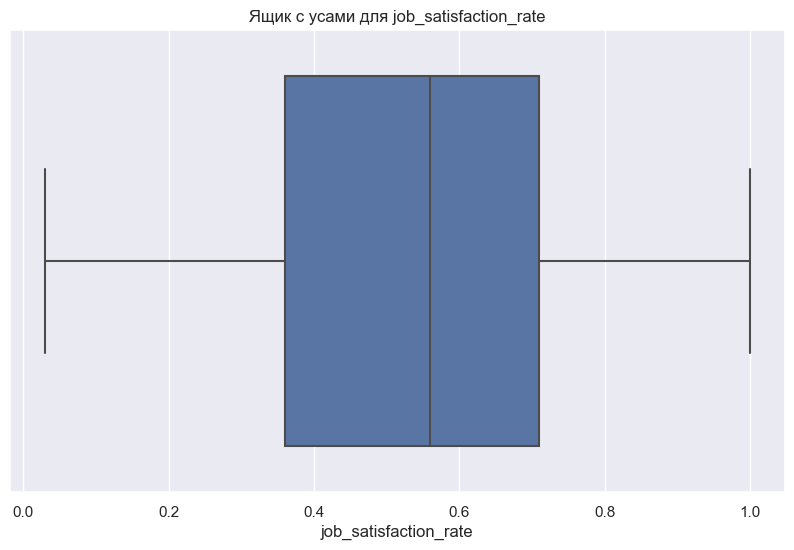

In [21]:
for num_col in num_col_train_job:
    create_histogram(df_train_job_satisfaction_rate, num_col)
    create_boxplot(df_train_job_satisfaction_rate, num_col)

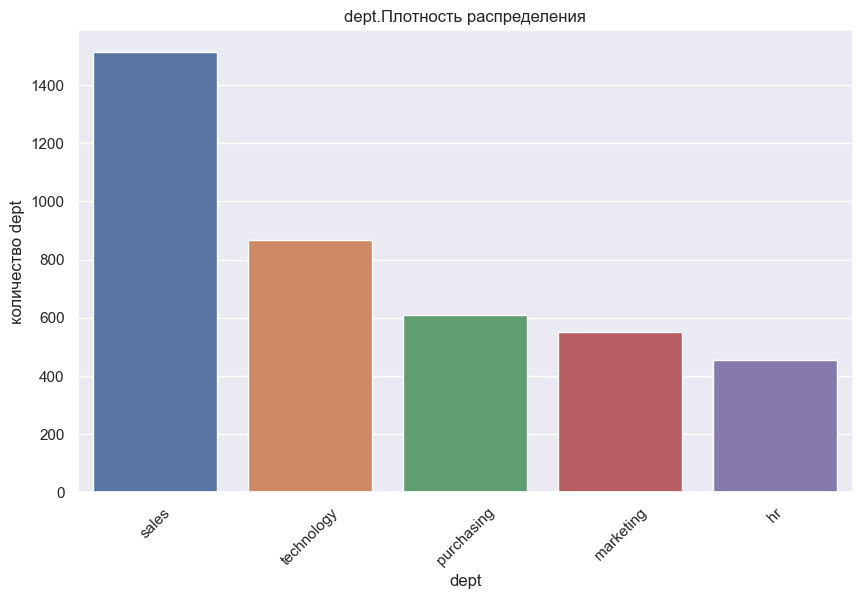

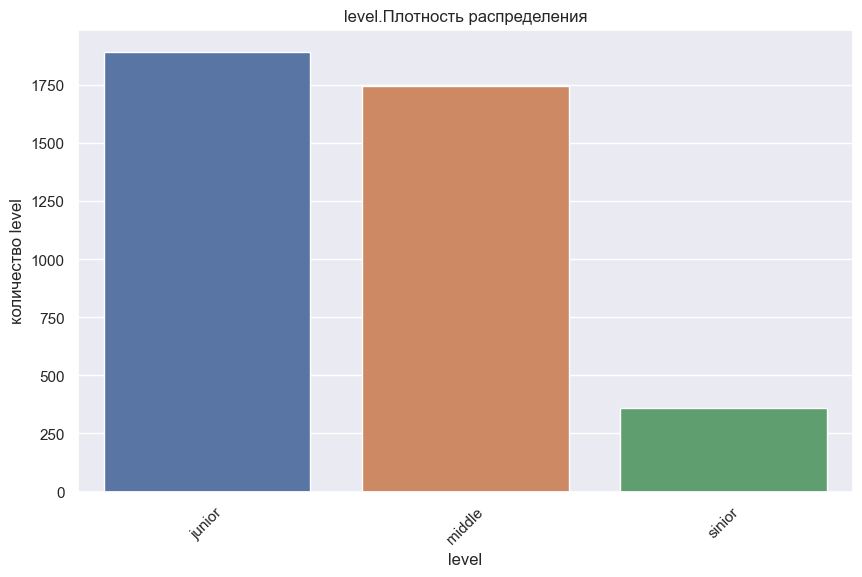

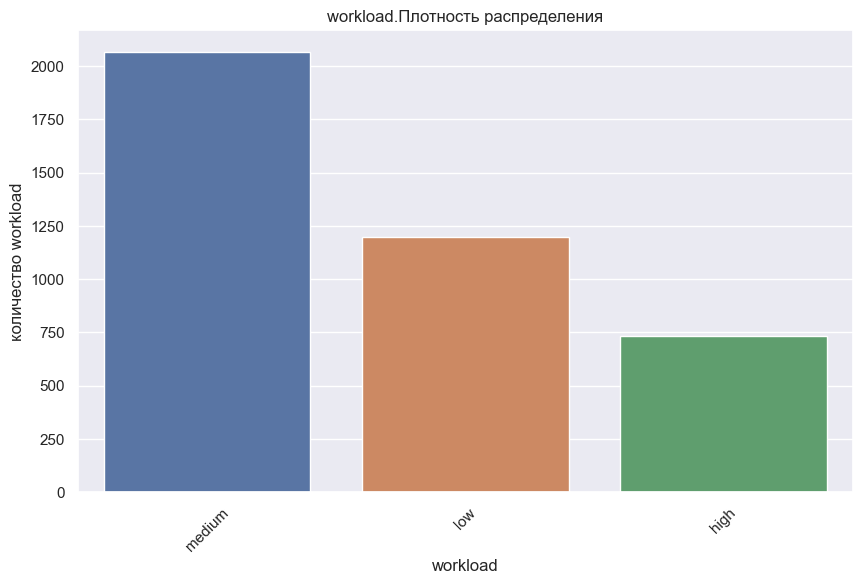

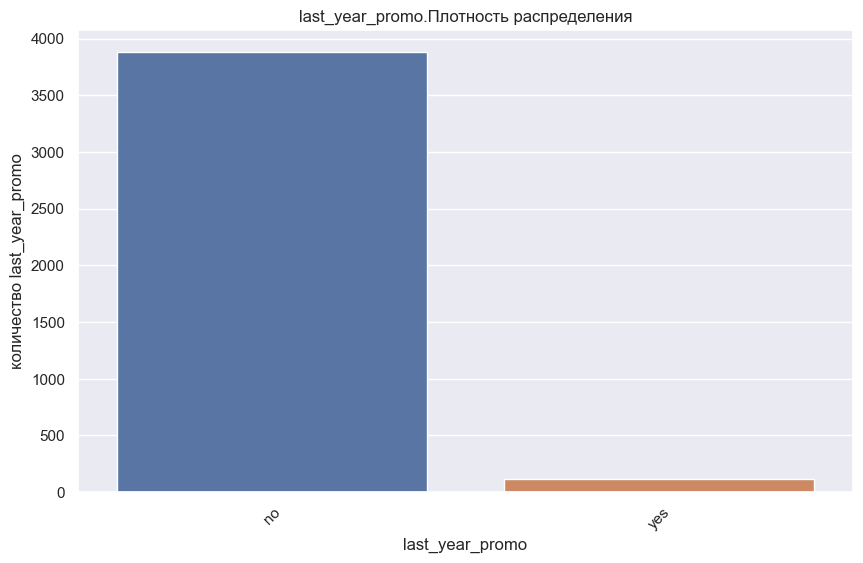

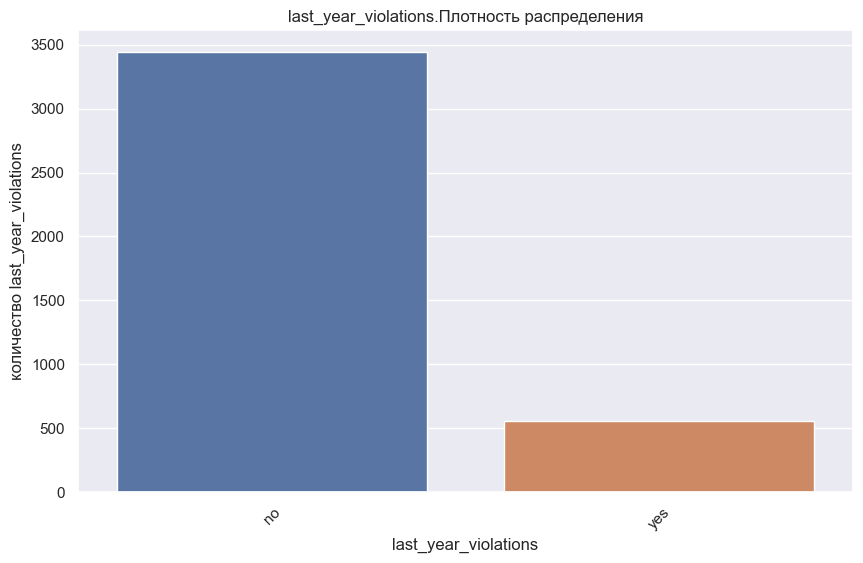

In [22]:
for cat_col in cat_col_train_job:
    create_barplot(df_train_job_satisfaction_rate, cat_col)

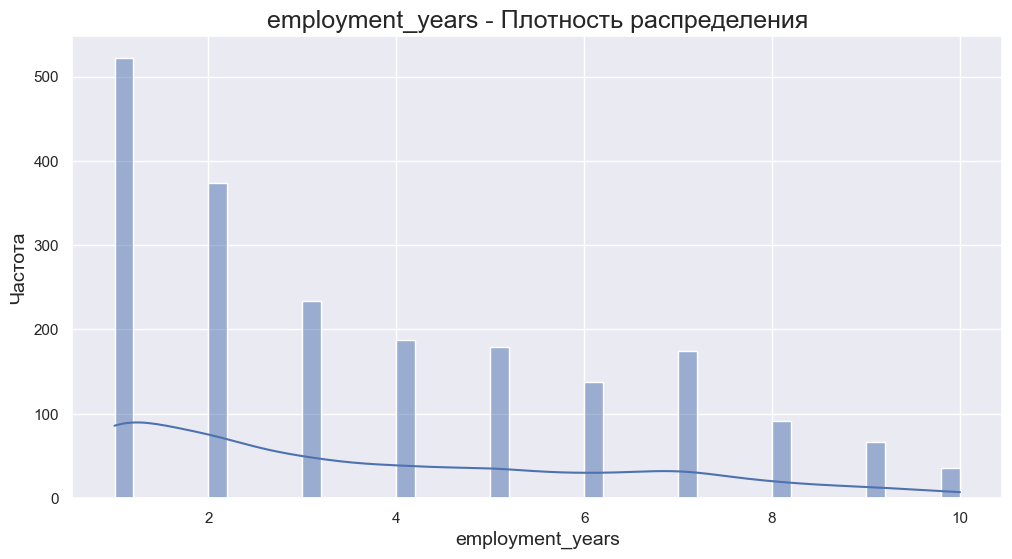

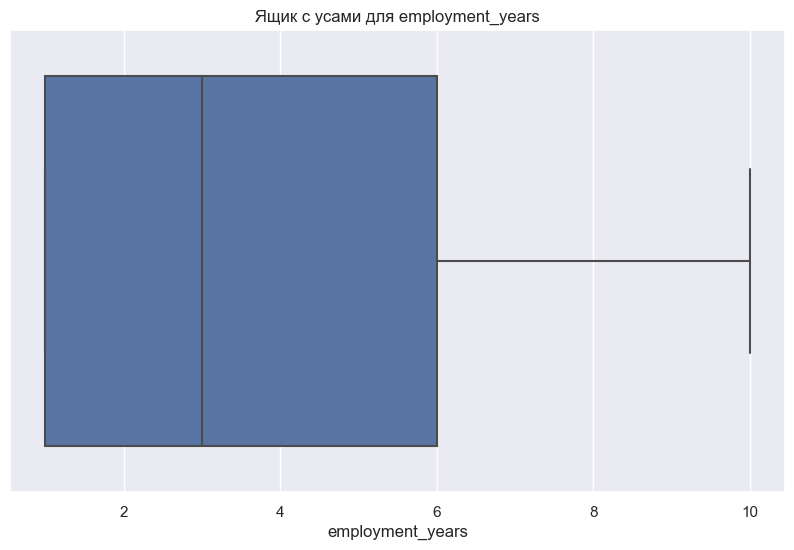

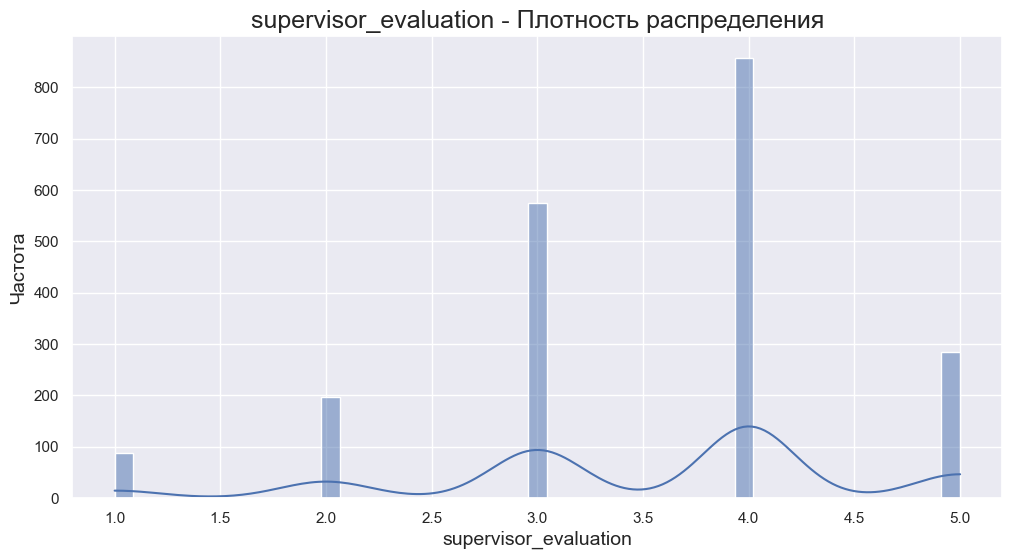

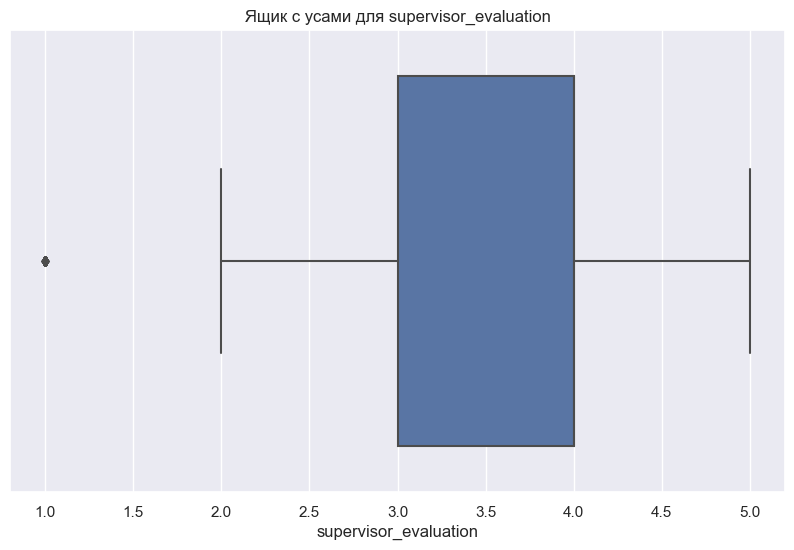

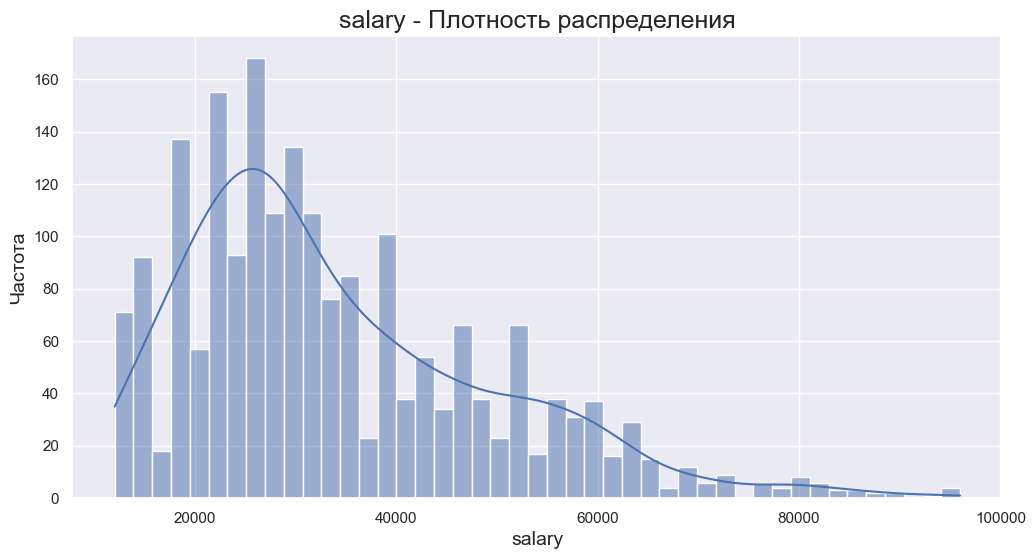

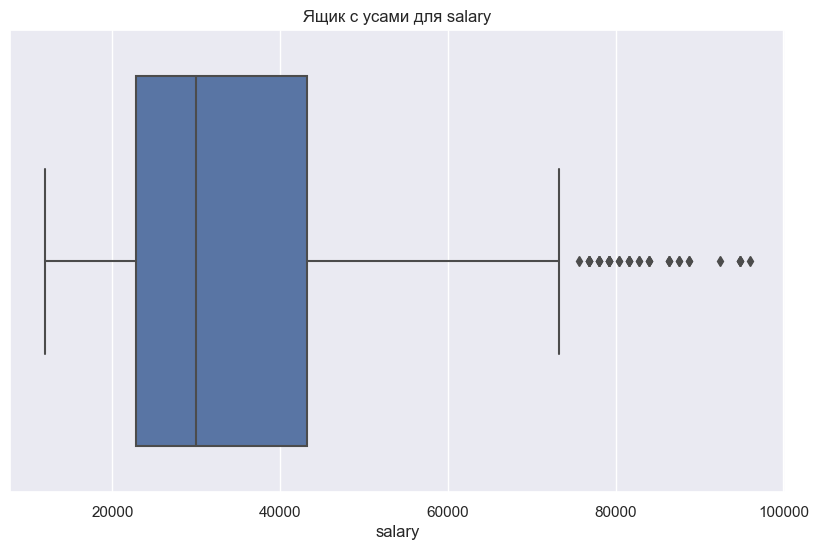

In [23]:
for num_col in num_col_test_features:
    create_histogram(df_test_features, num_col)
    create_boxplot(df_test_features, num_col)

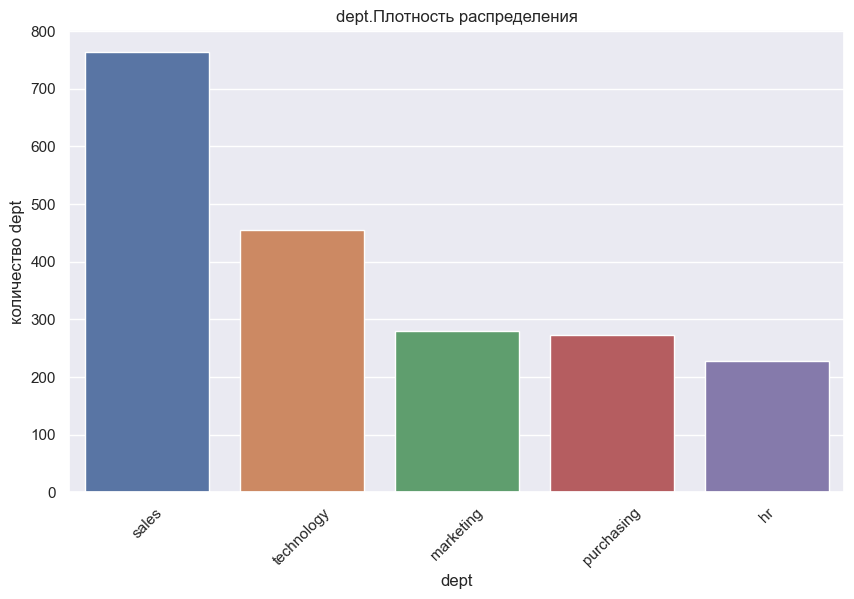

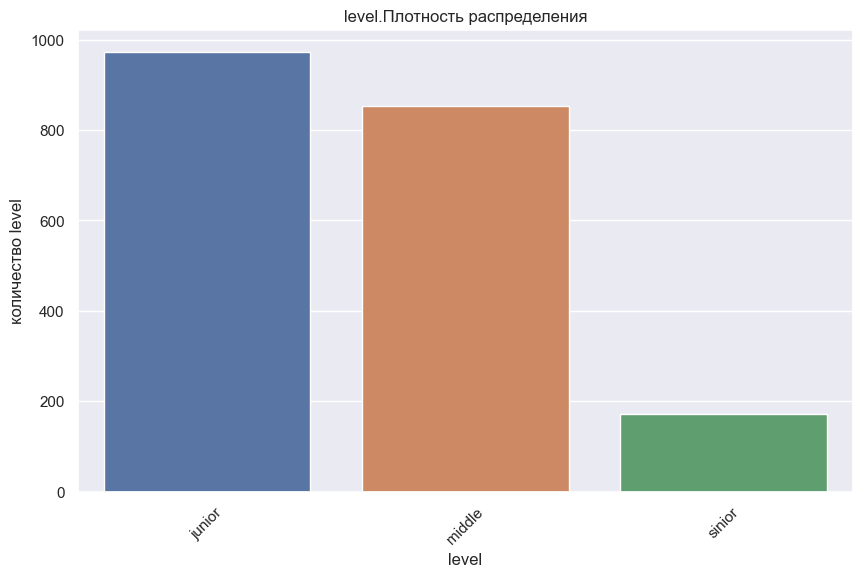

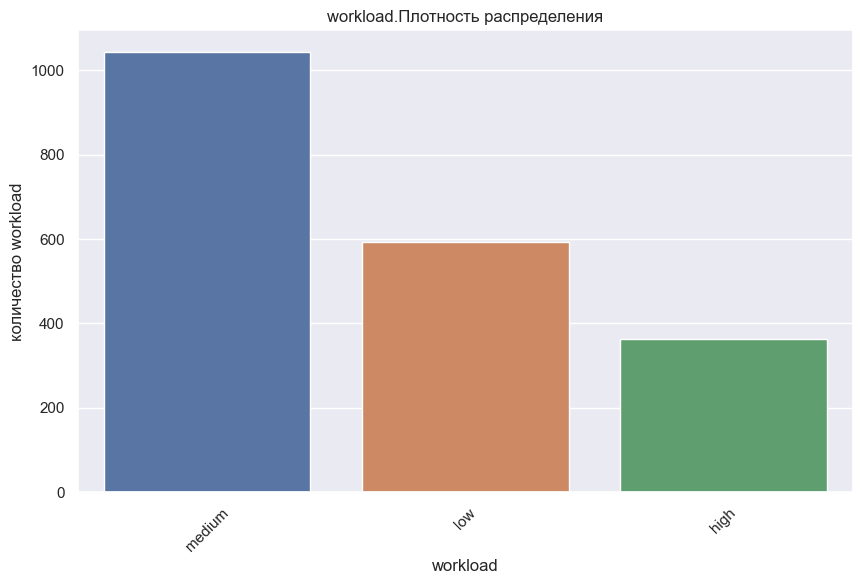

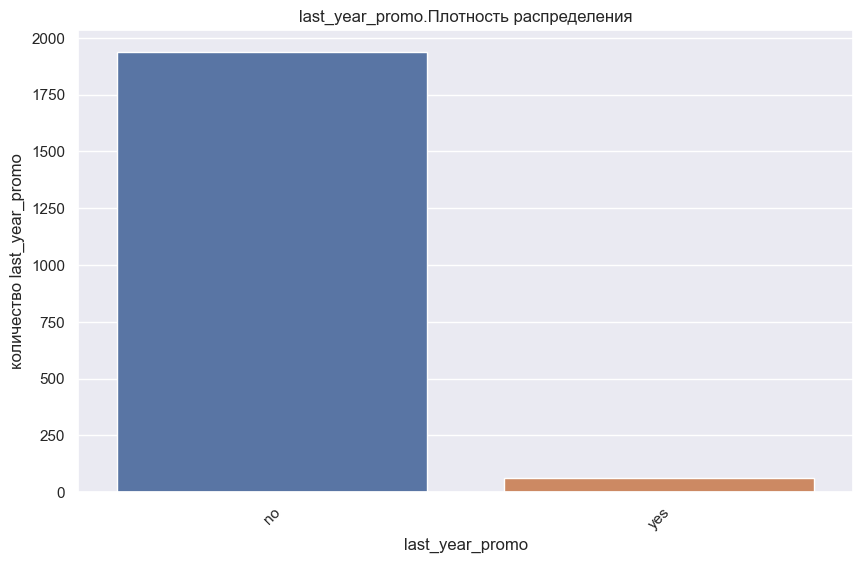

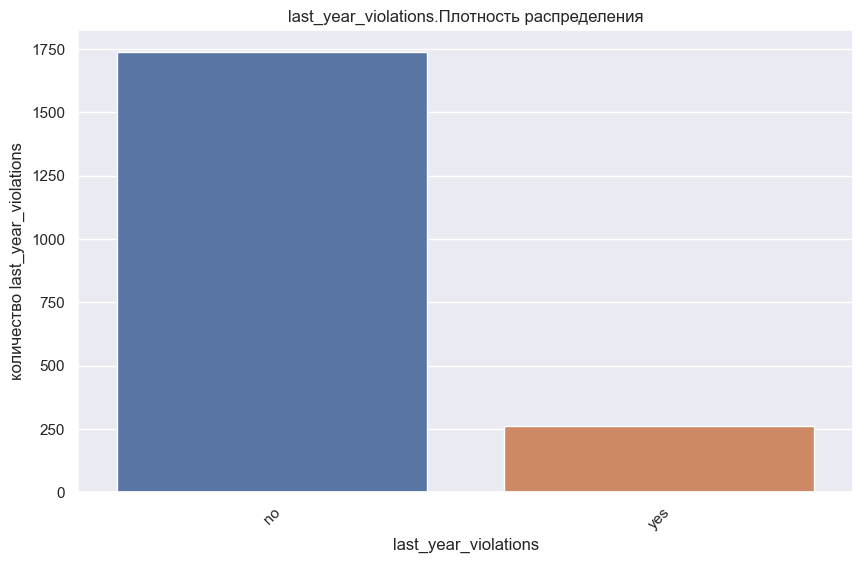

In [24]:
for cat_col in cat_col_train_job:
    create_barplot(df_test_features, cat_col)

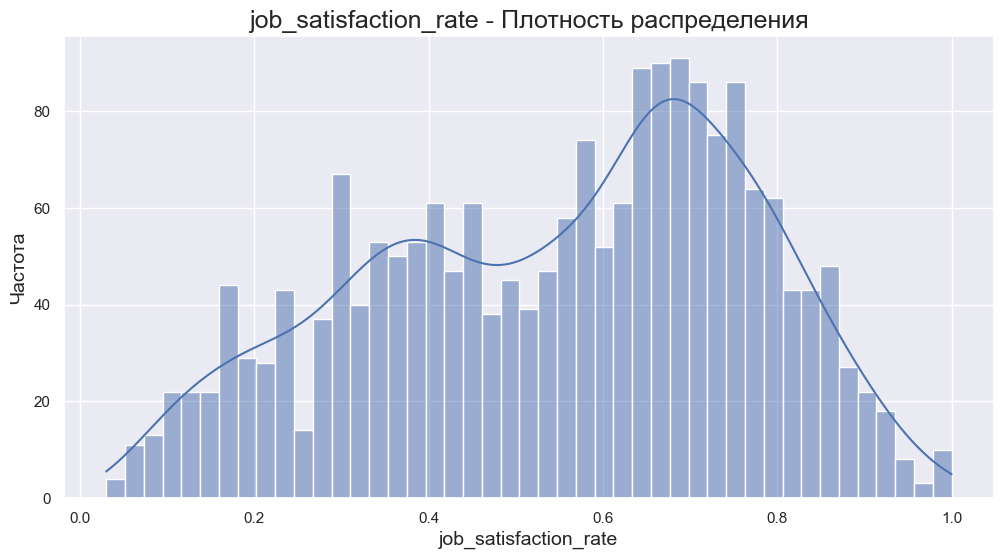

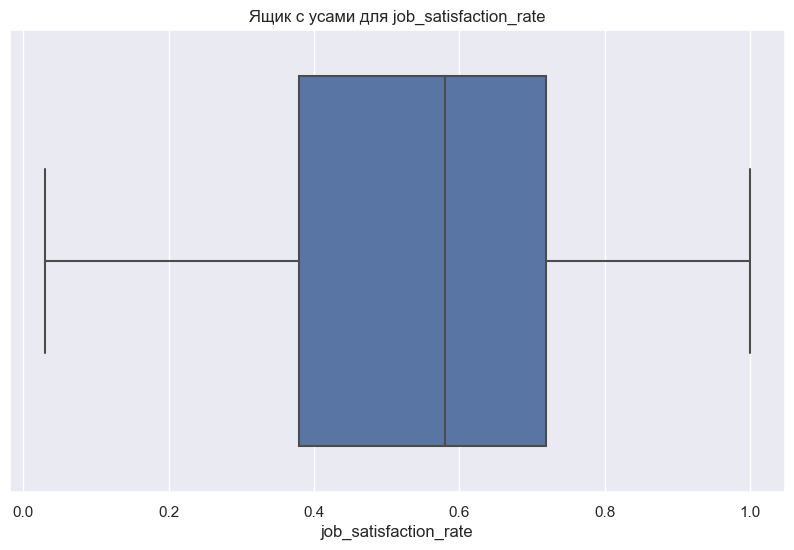

In [25]:
create_histogram(df_test_target_job_satisfaction_rate, 
                 'job_satisfaction_rate')

create_boxplot(df_test_target_job_satisfaction_rate, 
                 'job_satisfaction_rate')

В датафрейме df_train_job_satisfaction_rate в столбцах supervisor_evaluation и salary есть выбросы. Это не удивительно, так как сеньоров, как показали данные, в меньшинстве. И эта зарплата принадлежит топовым специлистам. Если мы удалим эти выбросы - модель может недообучиться, поэтому выбросы оставим, но будем использовать скалер, который более устойчив к выбросам. 

# Этап 4 Подготовка данных, создание модели

<a id="step_04"></a>

создаем списки колонок для двух кодировщиков 

In [26]:
ord_cols = ['level', 'workload', 'last_year_promo', 'last_year_violations']
ohe_cols = ['dept']


In [27]:
train_features = df_train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis=1)
train_target = df_train_job_satisfaction_rate['job_satisfaction_rate']


Так как данные в датафреймах тестовых данных перемешаны - отсортируем их по id, чтобы в дальнейшем не возникло ошибок 

In [28]:
df_test_combined = df_test_features.merge(df_test_target_job_satisfaction_rate, on='id')
print(f'количество дубликатов:{df_test_combined.duplicated().sum()}')
print()
print(f'количество пропусков:\n{df_test_combined.isna().sum()}')
print()
print(f'размерность датафрейма: {df_test_combined.shape}')
df_test_combined_target = df_test_combined['job_satisfaction_rate']
df_test_combined_features = df_test_combined.drop('job_satisfaction_rate', axis=1)

количество дубликатов:0

количество пропусков:
id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

размерность датафрейма: (2000, 10)


In [29]:
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
])

ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=[['junior', 'middle', 'senior'], 
                                       ['low', 'medium', 'high'], 
                                       ['no', 'yes'], 
                                       ['no', 'yes']],
                                         handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(strategy='most_frequent'))
])

numeric_pipe = Pipeline(steps=[
    ('scaler', RobustScaler())
])

# определение ColumnTransformer
data_preprocessor = ColumnTransformer(transformers=[
    ('ohe', ohe_pipe, ohe_cols),
    ('ord', ord_pipe, ord_cols),
    ('num', numeric_pipe, num_col_test_features)
], remainder='passthrough')

# создание основного пайплайна
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])


param_grid = [
    {'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
     'models__max_depth': range(2, 250),
     'models__max_features': range(2,50),
     'models__min_samples_leaf': range(1,5),
     'models__min_samples_split': range(2,20)
    },

    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
    },
    {
        'models': [LinearRegression()] 
    },
]


# определение функции SMAPE
def smape(y_test, pred): 
    metric = 100/len(y_test) * np.sum(2 * np.abs(pred - y_test) / (np.abs(y_test) + np.abs(pred)))
    return metric

# создание объекта RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=10,
    scoring=make_scorer(smape),
    n_jobs=-1,
    random_state=RANDOM_STATE
    )

# подгонка модели
random_search.fit(train_features, train_target)

# вывод лучшей модели и ее параметров
print('Лучшая модель и ее параметры:\n\n', random_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

pred = random_search.predict(df_test_combined_features)
score=make_scorer(smape)
smape_score = score(random_search.best_estimator_, df_test_combined_features, df_test_combined_target)
print(f'Метрика SMAPE на тестовой выборке: {smape_score}')


/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for t

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                               

# Задача 2

<a id="task_02"></a>

# Этап 1 Загрузка данных

<a id="step_11"></a>

In [30]:
try:
    df_train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
    df_test_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')
except FileNotFoundError:
    print()

In [31]:
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [32]:
df_train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [33]:
df_test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [34]:
df_test_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


## Вывод 
Для иследования увольнения сотрудника у нас есть 2 датафрейма. В одном находтся тренировочные данные, в другом таргетный признак тестовой выборки. Фичи тестовой выборки возьмем из прошлой задачи. Пропусков нет

# Этап 2. Предобработка данных

<a id="step_12"></a>

Изучим дубликаты

In [35]:
df_train_quit.duplicated().sum()

0

In [36]:
num_col_quit, cat_col_quit = cat_num_col(df_train_quit)

In [37]:
duplicates(cat_col_quit, df_train_quit)

Уникальные значения в колонке dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения в колонке level: ['middle' 'junior' 'sinior']
Уникальные значения в колонке workload: ['high' 'medium' 'low']
Уникальные значения в колонке last_year_promo: ['no' 'yes']
Уникальные значения в колонке last_year_violations: ['no' 'yes']
Уникальные значения в колонке quit: ['no' 'yes']


## Вывод 
Дубликатов не было обнаружено 

# Этап 3. Исследовательский анализ данных 


<a id="step_13"></a>

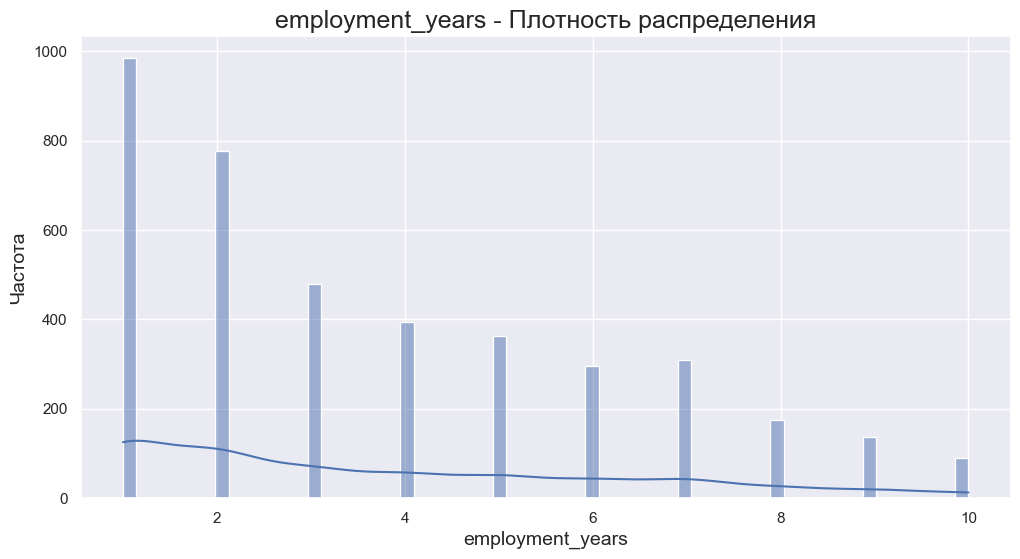

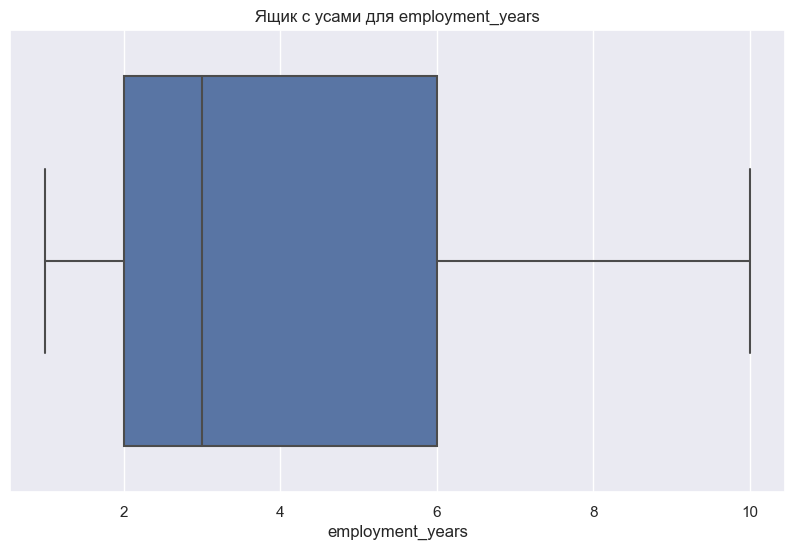

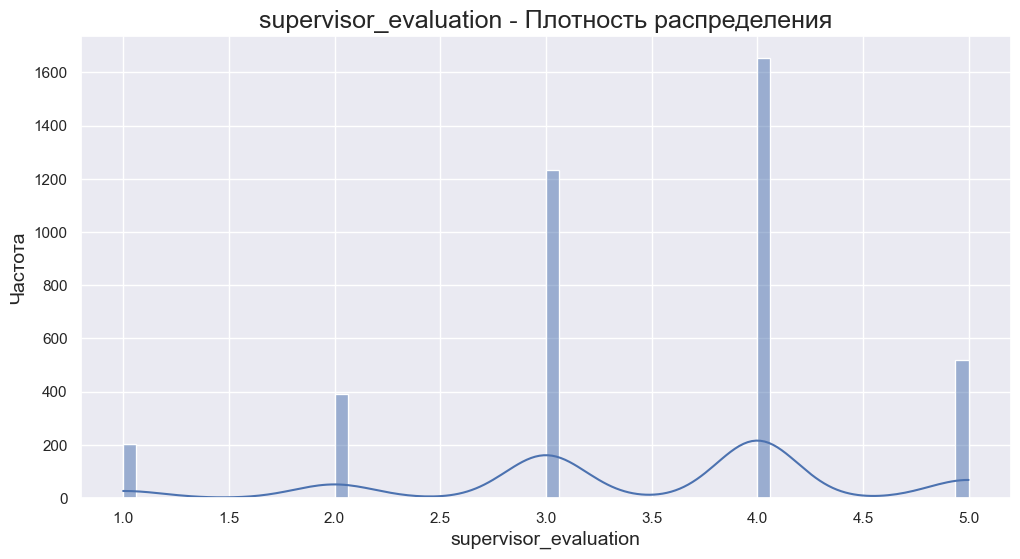

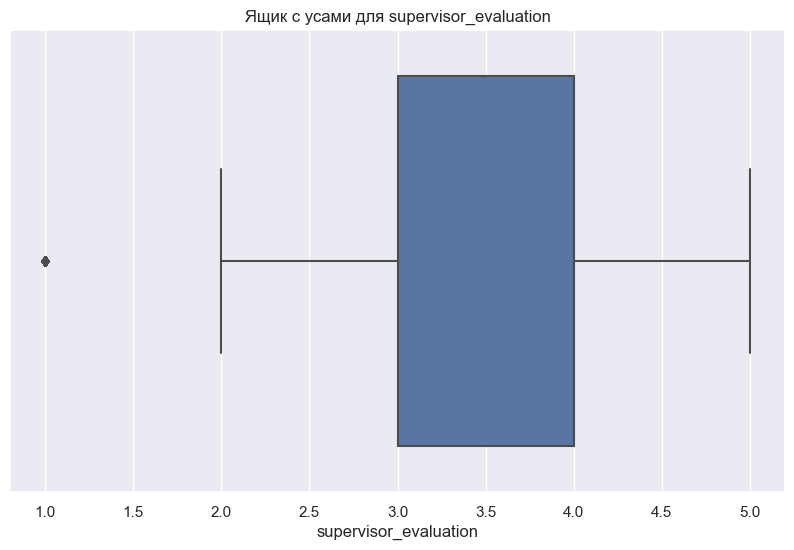

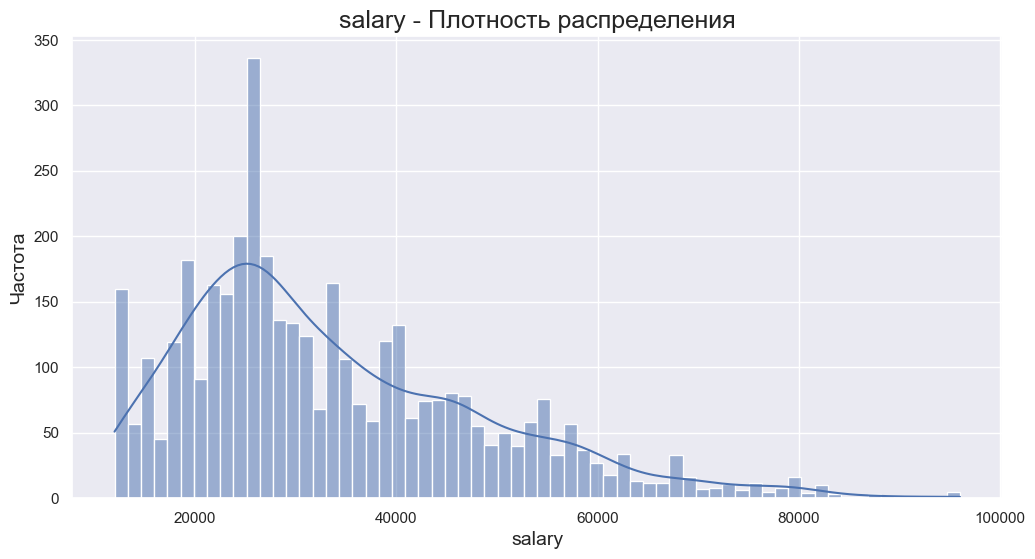

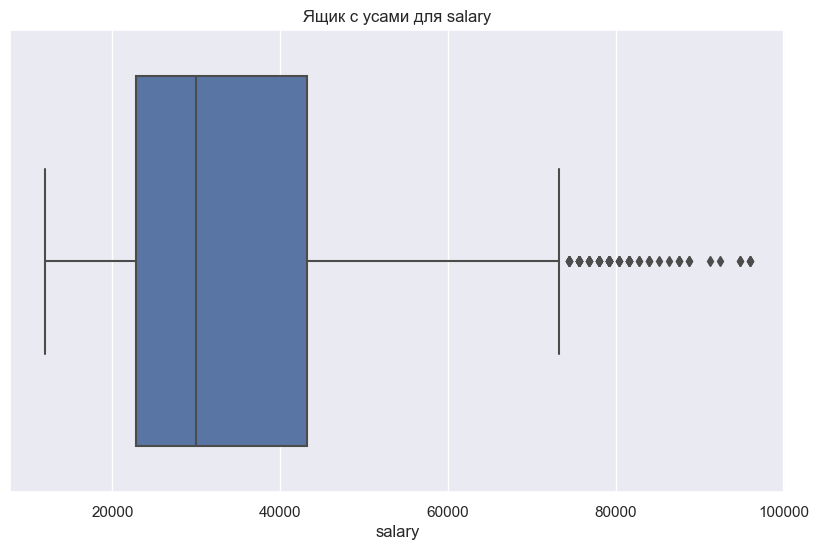

In [38]:
for num_name in num_col_quit:
    create_histogram(df_train_quit, num_name)
    create_boxplot(df_train_quit, num_name)

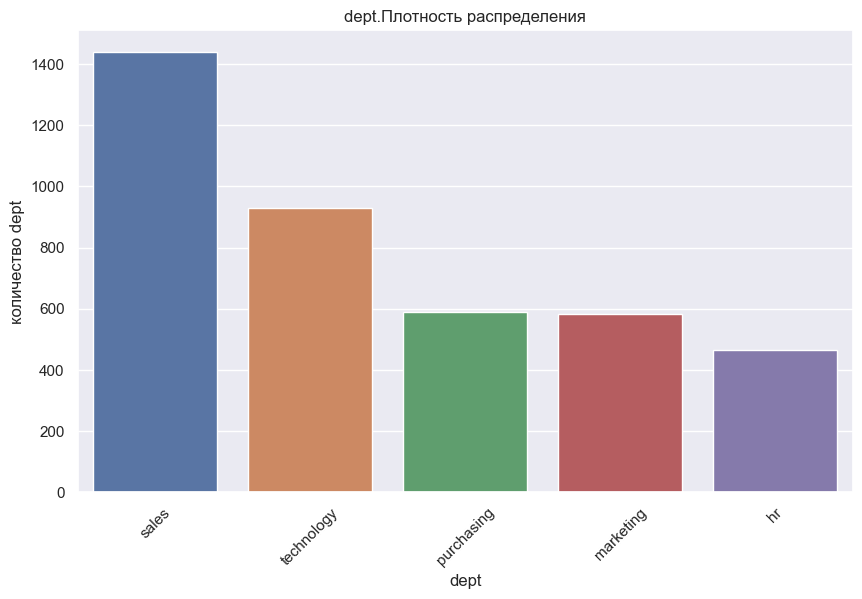

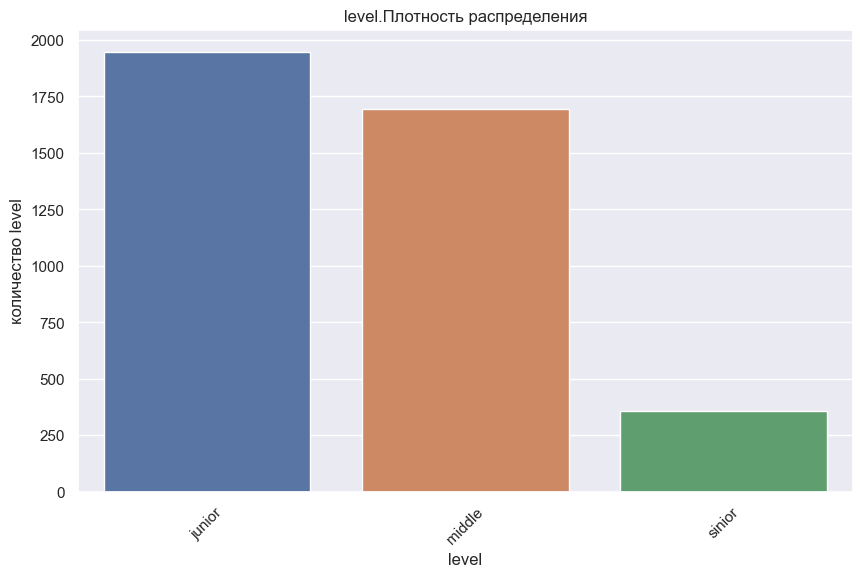

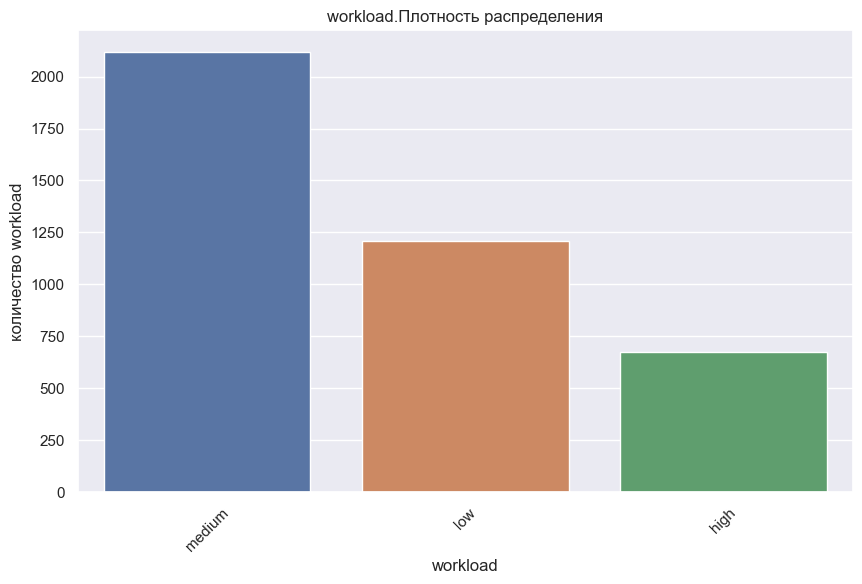

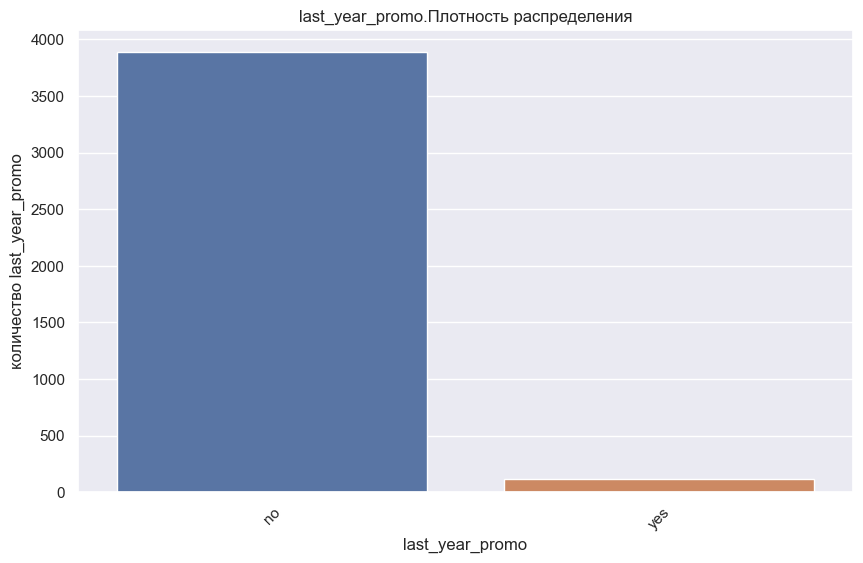

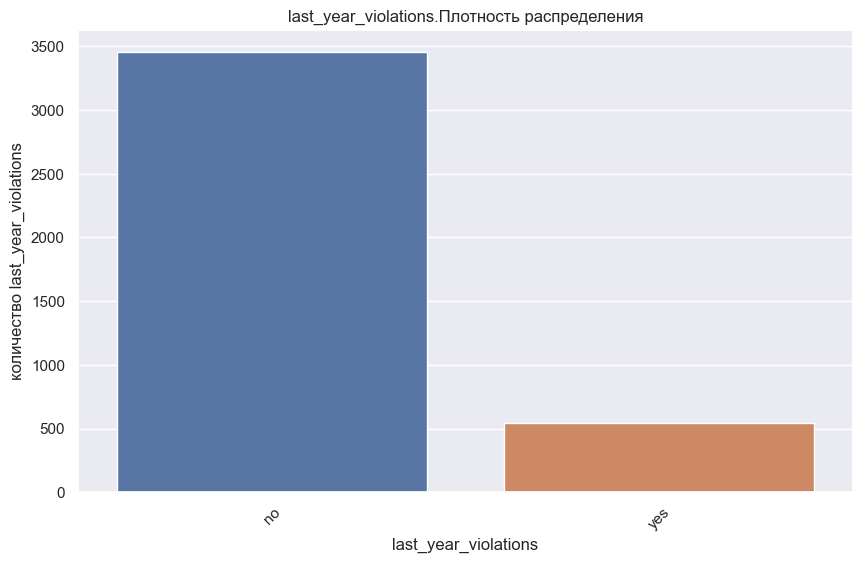

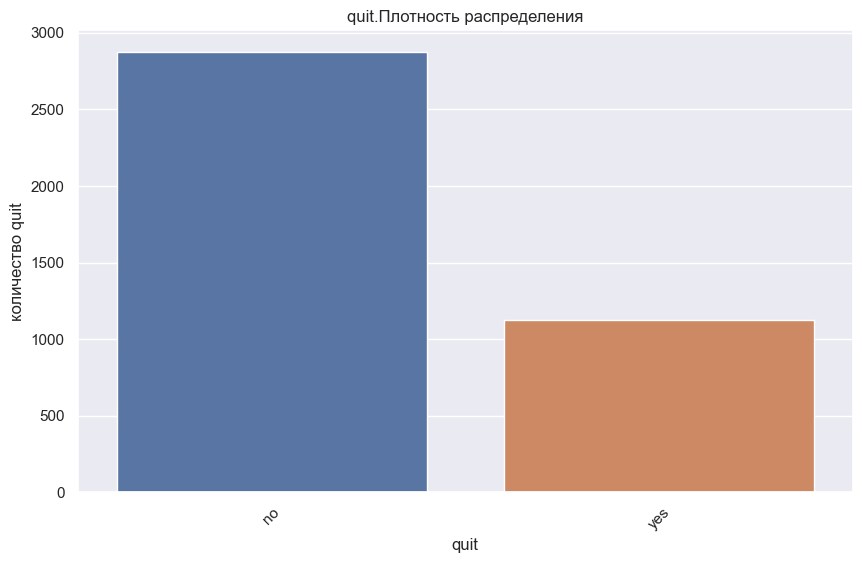

In [39]:
for cat_name in cat_col_quit:
    create_barplot(df_train_quit, cat_name)

По графикам у нас есть выбросы. Если их убрать - модель может недообучиться, поэтому выбросы оставим и выберем скалер, который устойчив к выбросам

**Портрет уволившегося сотрудника**

Выберем из датафрейма тех, кто уволился и посмотрим на графики 

In [40]:
df_quit_yes = df_train_quit[df_train_quit['quit'] == 'yes']
num_col_quit_yes, cat_col_quit_yes = cat_num_col(df_quit_yes)
df_quit_no = df_train_quit[df_train_quit['quit'] == 'no']

Также проверим среднюю зарплату уволивчшего сотрудника и того, кто остался работать

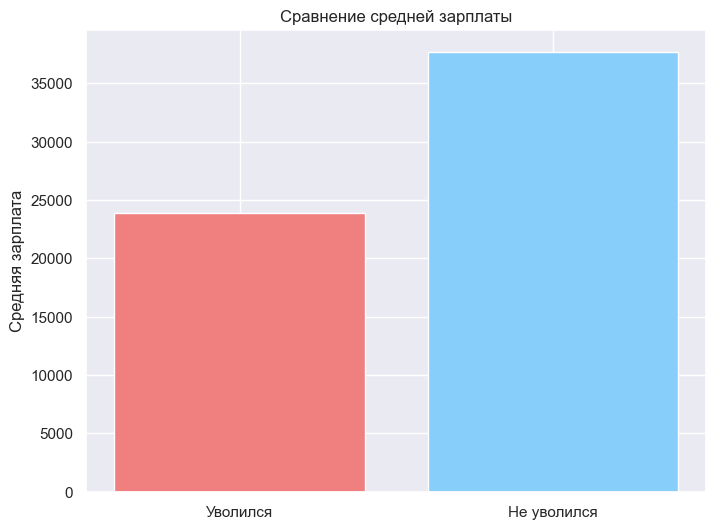

средняя зарплата уволившего сотрудника - 23885
средняя зарплата не уволившегося сотрудника - 37702
она больше на 13817


In [41]:
# Значения средней зарплаты
quit_yes_mean = round(df_quit_yes['salary'].mean())
quit_no_mean = round(df_quit_no['salary'].mean())

# Построение графика
plt.figure(figsize=(8, 6))
plt.bar(['Уволился', 'Не уволился'], [quit_yes_mean, quit_no_mean], color=['lightcoral', 'lightskyblue'])
plt.title('Сравнение средней зарплаты')
plt.ylabel('Средняя зарплата')
plt.show()

# Вывод информации о разнице в зарплате
print(f"средняя зарплата уволившего сотрудника - {quit_yes_mean}")
print(f"средняя зарплата не уволившегося сотрудника - {quit_no_mean}")
print(f"она больше на {round(quit_no_mean - quit_yes_mean)}")


Таким образом, у сотрудника, который уволился зарплата в среднем больше на 13 тысяч

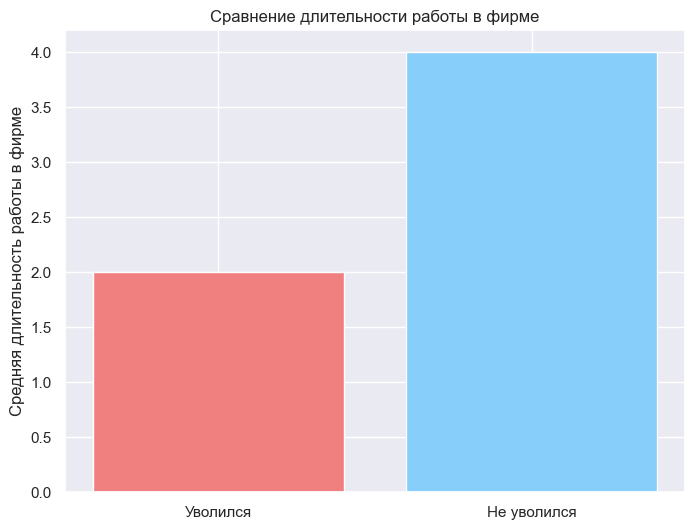

In [42]:
# Значения средней зарплаты
employment_years_yes_mean = round(df_quit_yes['employment_years'].mean())
employment_years_no_mean = round(df_quit_no['employment_years'].mean())

# Построение графика
plt.figure(figsize=(8, 6))
plt.bar(['Уволился', 'Не уволился'], [employment_years_yes_mean, employment_years_no_mean], color=['lightcoral', 'lightskyblue'])
plt.title('Сравнение длительности работы в фирме')
plt.ylabel('Средняя длительность работы в фирме')
plt.show()

По графиком видно, что в большнстве случаев увольняются сотрудники, которые проработали около 2х лет 

In [43]:
df_quit_no.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2872 entries, 0 to 3998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2872 non-null   int64 
 1   dept                   2872 non-null   object
 2   level                  2872 non-null   object
 3   workload               2872 non-null   object
 4   employment_years       2872 non-null   int64 
 5   last_year_promo        2872 non-null   object
 6   last_year_violations   2872 non-null   object
 7   supervisor_evaluation  2872 non-null   int64 
 8   salary                 2872 non-null   int64 
 9   quit                   2872 non-null   object
dtypes: int64(4), object(6)
memory usage: 246.8+ KB


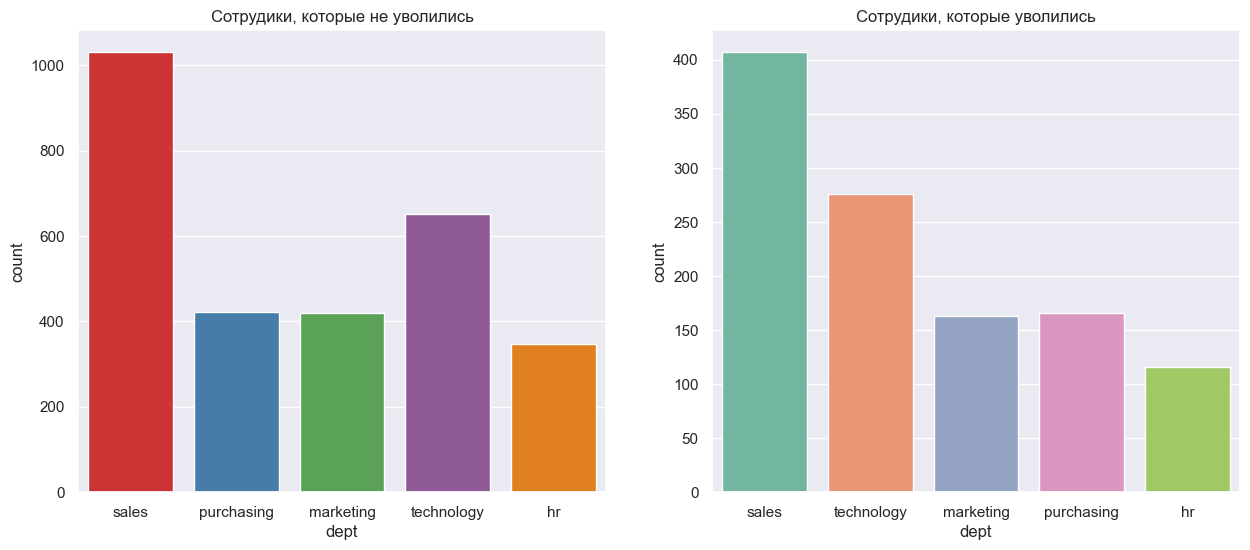

In [44]:
compare_df(df_quit_no, df_quit_yes, 'dept')

Из графиков видно, что больше всего увольенний (почти треть) в продажах, но там и больше всего сотрудников. Также много сотрудников уволилось в отделе "технологии", там также уволилась треть сотрудников. Меньше всего увольнений в отделе hr. 

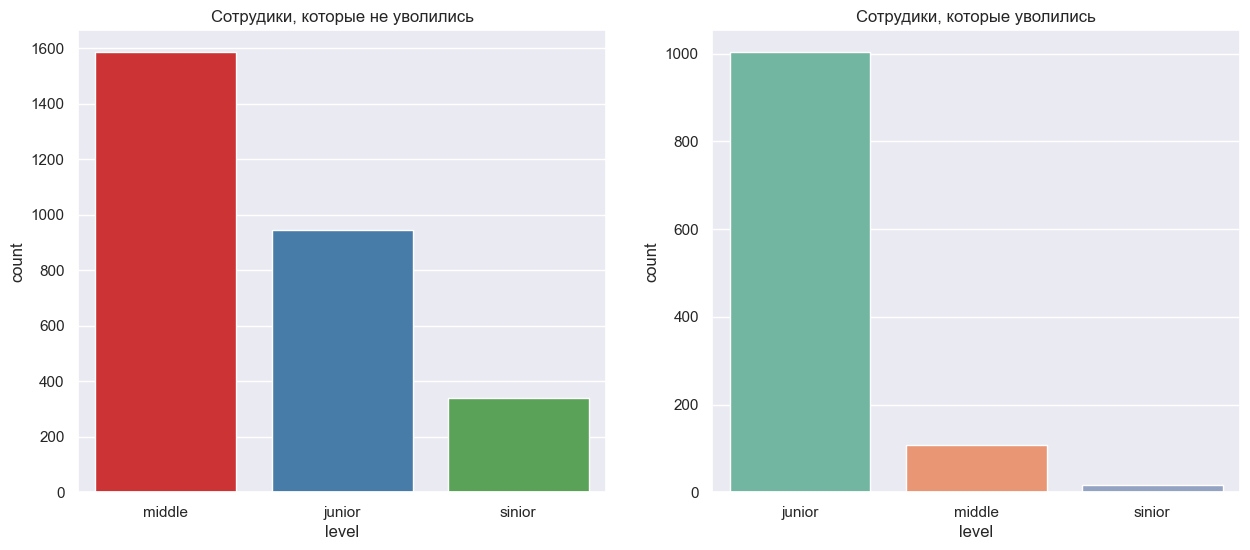

In [45]:
compare_df(df_quit_no, df_quit_yes, 'level')

Сеньеров, которые остались - меньше всего, но меньше всего среди них и уволилось. А вот половина джуниоров уволилась. Это может быть связано с ожиданиями зарплаты или с тем, что джуны неправильно оценили свои возможности и пошли повышать свою кваллификацию. Мидлов ушло тоже сравнительно мало

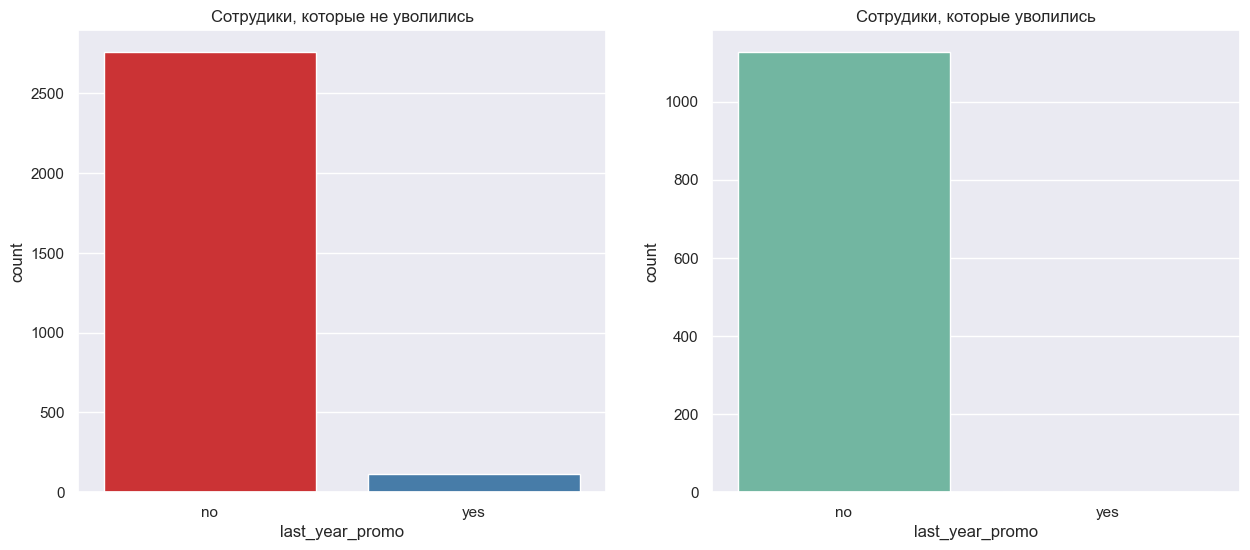

In [46]:
compare_df(df_quit_no, df_quit_yes, 'last_year_promo')

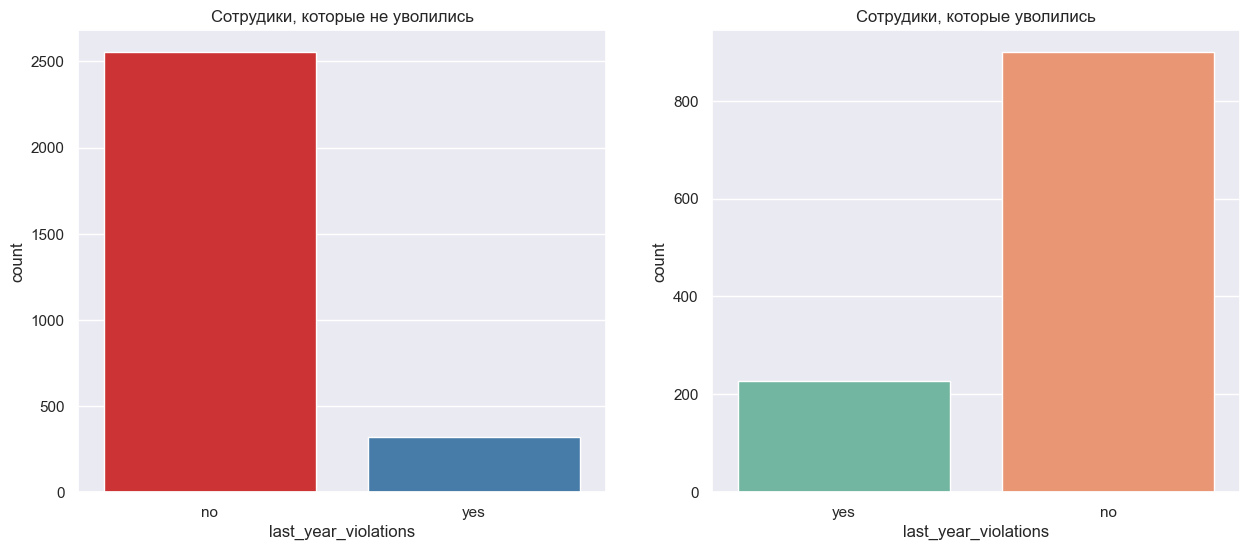

In [47]:
compare_df(df_quit_no, df_quit_yes, 'last_year_violations')

По графикам видно, что нарушение трудового договроа никак не повлияло на увольенние сотрудника

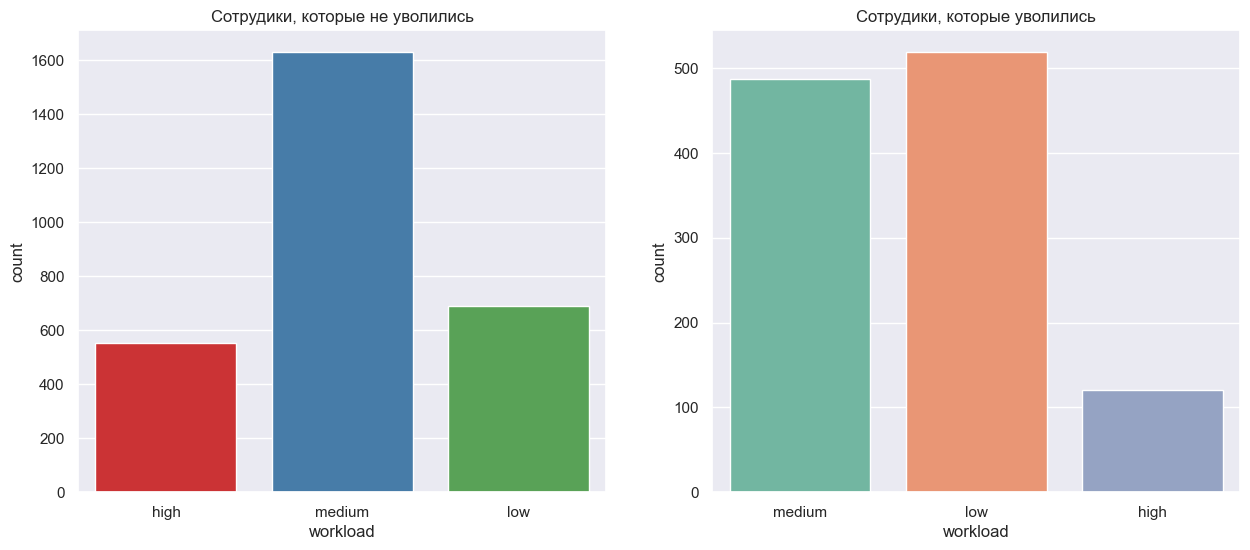

In [48]:
compare_df(df_quit_no, df_quit_yes, 'workload')

В компании больше всего остались сотрудники со средней загруженностью. И это, в целом, хорощо совпадает с тем, что у большинства уволившихся сотрудников небольшая зарплата и позиция джуна и уволились сотрудники с маленькой загруженностью

# 3 3 

In [49]:
df_test_final = df_test_combined.merge(df_test_quit, on='id')
print(f'количество дубликатов:{df_test_final.duplicated().sum()}')
print()
print(f'количество пропусков:\n{df_test_final.isna().sum()}')
print()
print(f'размерность датафрейма: {df_test_final.shape}')

количество дубликатов:0

количество пропусков:
id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
quit                     0
dtype: int64

размерность датафрейма: (2000, 11)


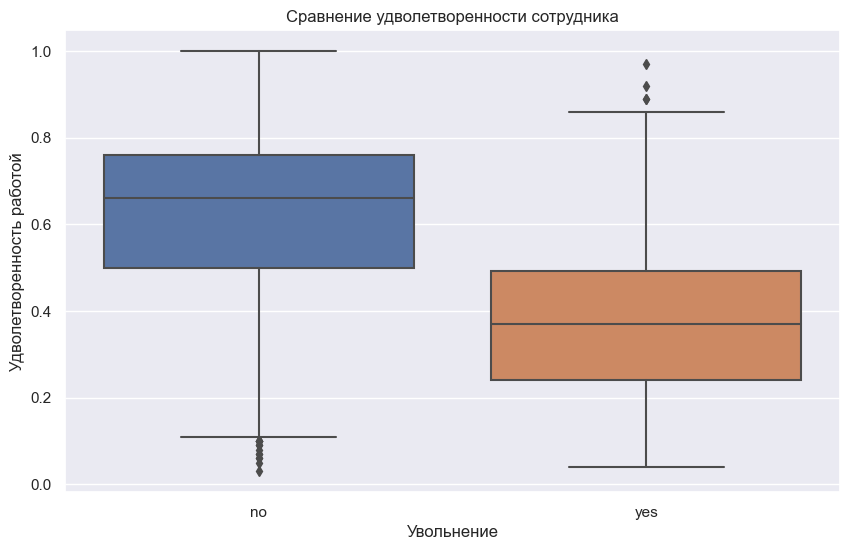

In [50]:
# Создание боксплота для сравнения распределений
plt.figure(figsize=(10, 6))
sns.boxplot(x='quit', y='job_satisfaction_rate', data=df_test_final)
plt.title('Сравнение удволетворенности сотрудника')
plt.xlabel('Увольнение')
plt.ylabel('Удволетворенность работой')
plt.show()


Сотрудники, которые остались в компании, обычно проявляют большее удовлетворение от работы, чем те, кто уволился. Более того, количество уволившихся сотрудников, которые были полностью удовлетворены своей работой, значительно меньше, и это отражается на графике в виде выбросов. Такая же тенденция наблюдается среди сотрудников, которые остались в компании, но при этом показывают низкий уровень удовлетворения от работы.

# Добавление нового признака

In [51]:
pred_2 = random_search.predict(df_train_quit)
df_train_quit['job_satisfaction_rate'] = pred_2
df_test_final['job_satisfaction_rate'] = pred
df_train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.6320
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.8725
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.3150
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.2920
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.9040


In [52]:
ord_cols_2 = ['level', 'workload', 'last_year_promo', 'last_year_violations']
ohe_cols_2 = ['dept'] 
num_cols_2 =  list(df_test_combined.select_dtypes(include=['int64', 'float64']).columns)
df_train_quit['quit'] = df_train_quit['quit'].replace({'yes': 1, 'no': 0})
df_test_final['quit'] = df_test_final['quit'].replace({'yes': 1, 'no': 0})
df_train_quit_features = df_train_quit.drop(['quit'], axis=1)
df_train_quit_target = df_train_quit['quit']
df_test_final_features = df_test_final.drop(['quit'], axis=1)
df_test_final_tagret = df_test_final['quit']

In [53]:
num_cols_2

['id',
 'employment_years',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

In [54]:
ohe_pipe_2 = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
])

ord_pipe_2 = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=[['junior', 'middle', 'senior'], 
                                       ['low', 'medium', 'high'], 
                                       ['yes', 'no'], 
                                       ['no', 'yes']],
                                         handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(strategy='most_frequent'))
])

num_pipe_2 = Pipeline(steps=[
    ('quantile', QuantileTransformer())
])

# определение ColumnTransformer
data_preprocessor_2 = ColumnTransformer(transformers=[
    ('ohe', ohe_pipe_2, ohe_cols_2),
    ('ord', ord_pipe_2, ord_cols_2),
    ('num', num_pipe_2, num_cols_2)
], remainder='passthrough')

# создание основного пайплайна
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])



In [193]:
df_test_final_tagret.head()

0    0
1    0
2    0
3    0
4    0
Name: quit, dtype: int64

In [55]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 250),
     'models__max_features': range(2,50),
     'models__min_samples_leaf': range(1,5),
     'models__min_samples_split': range(2,20)
    }, 
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': [1, 5, 10],
    }, 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': [5, 7, 9], 
    }
]

random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE)

random_search.fit(df_train_quit_features, df_train_quit_target)
print('Лучшая модель и ее параметры:\n\n', random_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

pred_quit = random_search.predict(df_test_final_features)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(df_test_final_tagret, pred_quit)}')

/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/preprocessing/_encoder

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                               

In [197]:
! pip install shap 